In [1]:
import xarray as xr
import dask.array
import numpy as np
import pandas as pd
import os
## warnings
import warnings
warnings.filterwarnings('ignore')
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
## plotting
import matplotlib.pyplot as plt
from matplotlib import gridspec
import cartopy.crs as ccrs
import cartopy.feature
import matplotlib.path as mpath
import matplotlib.ticker as mticker
import cmocean.cm as cm

In [2]:
LR_SOCCOM_dir = '/work/Ruth.Moorman/SOCCOM-floats/LR_SOCCOM_20200308/unprocessed_SOCCOM/'
float_file_list = os.listdir(LR_SOCCOM_dir)

In [3]:
len(float_file_list) # number of individual SOCCOM .nc files

155

In [4]:
# below I interpolate onto a depth dimension, if you want to retain the depth differences, you'll want to fill a
# blank, initialised array dimensions time, N_LEVEL, N_PROF, using the maximum N_LEVEL in the dataset
N_LEVEL_len = np.empty(len(float_file_list))
N_PROF_len = np.empty(len(float_file_list))
NPARAMETER_len = np.empty(len(float_file_list))
for i in range(len(N_LEVEL_len)):
    file = xr.open_dataset(LR_SOCCOM_dir+float_file_list[i])
    N_LEVEL_len[i] = len(file.N_LEVELS)
    N_PROF_len[i] = len(file.N_PROF)
    NPARAMETER_len[i] = len(file.NPARAMETER)
print('N_LEVEL: ',np.max(N_LEVEL_len))
print('N_PROF: ',np.sum(N_PROF_len))

N_LEVEL:  750.0
N_PROF:  14500.0


In [5]:
float_names = np.array(float_file_list)
print(float_names[np.where(NPARAMETER_len <=40, True, False)]) ## these files do not contain the TALK/ DIC/ pCO2 variables
carbon_float_names = float_names[np.where(NPARAMETER_len >40, True, False)] # alternate to float_names to be used for carbon variables

['0037SOOCNQC.nc' '6091SOOCNQC.nc' '7557SOOCNQC.nc' '7567SOOCNQC.nc'
 '7613SOOCNQC.nc' '7614SOOCNQC.nc' '7652SOOCNQC.nc']


In [13]:
def interpolated_SOCCOM_floats(variable, interp_depths, float_dir, float_names):
    """
    Aggregates all SOCCOM float data in the filepath float_dir into a single xarray datastructure with dimensions 
    N_PROF and depth.
    Note: float_dir must contain ONLY the float .nc files. This function will extract the full contents of the directory.
    
    depth_bin dimension is determined interpolating SOCCOM float data onto the input interp_depths dimension
    using 4 interpolation methods: linear, nearest neighbour, cubic spline and quadratic spline (so later uncertainty 
    associated with the interpolation method may be quantified). Obviously you can adjust to remove some interpolation 
    methods if you just want one.
    
    Inputs:
    variable is a string that is set to one of the following:
    
    Temperature
    Salinity
    Sigma_theta
    Oxygen
    Nitrate
    Chl_a
    POC
    TALK
    DIC
    
    interp_depths is a numpy array of the depth dimension one wants to interpolate onto
    
    float_dir is the directory containing the float .nc files
    
    float_names is an array of strings of the .nc file filenames (note some may need to be excluded in the case that a given file only contains a subset of variables)
    
    will return 4 DataArray structures associated with the 4 interpolation methods.
    return tracer_linear, tracer_nearest_neighbour, tracer_cubic, tracer_quadratic
    
    (change function if using CANYON or MLR versions of TALK, DIC, pCO2, some names are different I think)
    Note, not all floats have TALK/ DIC/ pCO2 values, may need different float_names for these (see 'carbon_float_names' in notebook)
    Ruth Moorman, Princeton University, Mar 2020
    """
        
    ################################### initialise tracer array with first float ###################################
    float_file = xr.open_dataset(float_dir+float_names[0])
    float_lons = float_file.Lon.values
    float_lats = float_file.Lat.values
    float_times = float_file.JULD.values
    float_nc = np.zeros(len(float_lons)).astype('str')
    float_nc[:] = float_names[0]

    if variable == 'Temperature':
        tracer = float_file.Temperature
        units = tracer.units
        QC_mask = float_file.Temperature_QFA.where(float_file.Temperature_QFA ==0)+1 # code 0 is QC approved data
        tracer = tracer * QC_mask
    elif variable == 'Salinity':
        tracer = float_file.Salinity
        units = tracer.units
        QC_mask = float_file.Salinity_QFA.where(float_file.Salinity_QFA ==0)+1 
        tracer = tracer * QC_mask
    elif variable == 'Sigma_theta':
        tracer = float_file.Sigma_theta
        units = tracer.units
        QC_mask = float_file.Sigma_theta_QFA.where(float_file.Sigma_theta_QFA ==0)+1 
        tracer = tracer * QC_mask
    elif variable == 'Oxygen':
        tracer = float_file.Oxygen
        units = tracer.units
        QC_mask = float_file.Oxygen_QFA.where(float_file.Oxygen_QFA ==0)+1 
        tracer = tracer * QC_mask
    elif variable == 'Nitrate':
        tracer = float_file.Nitrate
        units = tracer.units
        QC_mask = float_file.Nitrate_QFA.where(float_file.Nitrate_QFA ==0)+1 
        tracer = tracer * QC_mask
        tracer = tracer.where(tracer >0) # there were negative concentrations, unsure how this wasn't picked up in the QC flag
    elif variable == 'Chl_a':
        tracer = float_file.Chl_a
        units = tracer.units
        QC_mask = float_file.Chl_a_QFA.where(float_file.Chl_a_QFA ==0)+1 
        tracer = tracer * QC_mask
    elif variable == 'POC':
        tracer = float_file.POC
        units = tracer.units
        QC_mask = float_file.POC_QFA.where(float_file.POC_QFA ==0)+1 
        tracer = tracer * QC_mask
    elif variable == 'TALK':
        tracer = float_file.TALK_LIAR
        units = tracer.units
        QC_mask = float_file.TALK_LIAR_QFA.where(float_file.TALK_LIAR_QFA ==0)+1 
        tracer = tracer * QC_mask
    elif variable == 'DIC':
        tracer = float_file.DIC_LIAR
        units = tracer.units
        QC_mask = float_file.DIC_LIAR_QFA.where(float_file.DIC_LIAR_QFA ==0)+1 
        tracer = tracer * QC_mask
    else:
        return print('Use valid variable option, help(gridded_SOCCOM_floats) for options')
    
    
    
    soccom_tracer_linear = xr.DataArray(np.empty((len(float_file.N_PROF), len(interp_depths))),coords = [float_file.N_PROF,interp_depths],dims = ['N_PROF','depth'])
    soccom_tracer_nearest = xr.DataArray(np.empty((len(float_file.N_PROF), len(interp_depths))),coords = [float_file.N_PROF,interp_depths],dims = ['N_PROF','depth'])
    soccom_tracer_cubic = xr.DataArray(np.empty((len(float_file.N_PROF), len(interp_depths))),coords = [float_file.N_PROF,interp_depths],dims = ['N_PROF','depth'])
    soccom_tracer_quad = xr.DataArray(np.empty((len(float_file.N_PROF), len(interp_depths))),coords = [float_file.N_PROF,interp_depths],dims = ['N_PROF','depth'])

    soccom_tracer_linear[:,:] = np.nan
    soccom_tracer_nearest[:,:] = np.nan
    soccom_tracer_cubic[:,:] = np.nan
    soccom_tracer_quad[:,:] = np.nan
    
    for i in range(len(float_file.N_PROF)):
        tracer_i = tracer.isel(N_PROF =i)
        tracer_i.coords['N_LEVELS'] = float_file.Depth.isel(N_PROF =i).values
        tracer_i = tracer_i.rename({'N_LEVELS':'depth'})
        tracer_i=tracer_i.where(np.abs(tracer_i)>0,drop = True ) # remove nans, they muck up interpolation
        tracer_i = tracer_i.where(np.abs(tracer_i.depth)>0,drop = True ) #nans aren't removed by uniqueness filter below
        _, unique_depth_index = np.unique(tracer_i.depth, return_index=True) # remove repeat depth measurements, again, they muck up interpolation (they don't seem to be common, I'm not concerned by removing)
        tracer_i = tracer_i.isel(depth = unique_depth_index)
        if len(tracer_i.depth) > 10: # you can alter this threshold, just needs to be at least 3 otherwise the interpolation methods fail
            soccom_tracer_linear[i,:] = tracer_i.interp(depth = interp_depths, method = 'linear')
            soccom_tracer_cubic[i,:] = tracer_i.interp(depth = interp_depths, method = 'cubic')
            soccom_tracer_nearest[i,:] = tracer_i.interp(depth = interp_depths, method = 'nearest')
            soccom_tracer_quad[i,:] = tracer_i.interp(depth = interp_depths, method = 'quadratic')
        else: 
            fill = np.empty((len(interp_depths)))
            fill[:] = np.nan
            soccom_tracer_linear[i,:] = fill
            soccom_tracer_cubic[i,:] = fill
            soccom_tracer_nearest[i,:] = fill
            soccom_tracer_quad[i,:] = fill
                
    count = len(float_file.N_PROF)
    
    ############################################ gather data from all floats #########################################
    for j in range(1,len(float_names)):
        float_file = xr.open_dataset(float_dir+float_names[j])

        ## record lat, lon, name, time
        float_lons = np.append(float_lons, float_file.Lon.values)
        float_lats = np.append(float_lats, float_file.Lat.values)
        float_times = np.append(float_times, float_file.JULD.values)
        float_nc_j = np.zeros(len(float_file.Lon.values)).astype('str')
        float_nc_j[:] = float_names[j]
        float_nc = np.append(float_nc, float_nc_j)

        if variable == 'Temperature':
            tracer = float_file.Temperature
            units = tracer.units
            QC_mask = float_file.Temperature_QFA.where(float_file.Temperature_QFA ==0)+1 # code 0 is QC approved data
            tracer = tracer * QC_mask
        elif variable == 'Salinity':
            tracer = float_file.Salinity
            units = tracer.units
            QC_mask = float_file.Salinity_QFA.where(float_file.Salinity_QFA ==0)+1 
            tracer = tracer * QC_mask
        elif variable == 'Sigma_theta':
            tracer = float_file.Sigma_theta
            units = tracer.units
            QC_mask = float_file.Sigma_theta_QFA.where(float_file.Sigma_theta_QFA ==0)+1 
            tracer = tracer * QC_mask
        elif variable == 'Oxygen':
            tracer = float_file.Oxygen
            units = tracer.units
            QC_mask = float_file.Oxygen_QFA.where(float_file.Oxygen_QFA ==0)+1 
            tracer = tracer * QC_mask
        elif variable == 'Nitrate':
            tracer = float_file.Nitrate
            units = tracer.units
            QC_mask = float_file.Nitrate_QFA.where(float_file.Nitrate_QFA ==0)+1 
            tracer = tracer * QC_mask
            tracer = tracer.where(tracer >0) # there were negative concentrations, unsure how this wasn't picked up in the QC flag 
        elif variable == 'Chl_a':
            tracer = float_file.Chl_a
            units = tracer.units
            QC_mask = float_file.Chl_a_QFA.where(float_file.Chl_a_QFA ==0)+1 
            tracer = tracer * QC_mask
        elif variable == 'POC':
            tracer = float_file.POC
            units = tracer.units
            QC_mask = float_file.POC_QFA.where(float_file.POC_QFA ==0)+1 
            tracer = tracer * QC_mask
        elif variable == 'TALK':
            tracer = float_file.TALK_LIAR
            units = tracer.units
            QC_mask = float_file.TALK_LIAR_QFA.where(float_file.TALK_LIAR_QFA ==0)+1 
            tracer = tracer * QC_mask
        elif variable == 'DIC':
            tracer = float_file.DIC_LIAR
            units = tracer.units
            QC_mask = float_file.DIC_LIAR_QFA.where(float_file.DIC_LIAR_QFA ==0)+1 
            tracer = tracer * QC_mask
        else:
            return print('Use valid variable option, help(gridded_SOCCOM_floats) for options')
        
        
        tracer_linear = xr.DataArray(np.empty((len(float_file.N_PROF), len(interp_depths))),coords = [float_file.N_PROF,interp_depths],dims = ['N_PROF','depth'])
        tracer_nearest = xr.DataArray(np.empty((len(float_file.N_PROF), len(interp_depths))),coords = [float_file.N_PROF,interp_depths],dims = ['N_PROF','depth'])
        tracer_cubic = xr.DataArray(np.empty((len(float_file.N_PROF), len(interp_depths))),coords = [float_file.N_PROF,interp_depths],dims = ['N_PROF','depth'])
        tracer_quad = xr.DataArray(np.empty((len(float_file.N_PROF), len(interp_depths))),coords = [float_file.N_PROF,interp_depths],dims = ['N_PROF','depth'])
        
        tracer_linear[:,:] = np.nan
        tracer_nearest[:,:] = np.nan
        tracer_cubic[:,:] = np.nan
        tracer_quad[:,:] = np.nan
        
        for i in range(len(float_file.N_PROF)):
            tracer_i = tracer.isel(N_PROF =i)
            tracer_i.coords['N_LEVELS'] = float_file.Depth.isel(N_PROF =i).values
            tracer_i = tracer_i.rename({'N_LEVELS':'depth'})
            tracer_i=tracer_i.where(np.abs(tracer_i)>0,drop = True ) # remove nans, they muck up interpolation
            tracer_i = tracer_i.where(np.abs(tracer_i.depth)>0,drop = True ) #nans aren't removed by uniqueness filter below and non uniqueness interferes with the interpolation protocol
            _, unique_depth_index = np.unique(tracer_i.depth, return_index=True) # remove repeat depth measurements, again, they muck up interpolation (they don't seem to be common, I'm not concerned by removing)
            tracer_i = tracer_i.isel(depth = unique_depth_index)
            if len(tracer_i.depth) > 10:
                tracer_linear[i,:] = tracer_i.interp(depth = interp_depths, method = 'linear')
                tracer_cubic[i,:] = tracer_i.interp(depth = interp_depths, method = 'cubic')
                tracer_nearest[i,:] = tracer_i.interp(depth = interp_depths, method = 'nearest')
                tracer_quad[i,:] = tracer_i.interp(depth = interp_depths, method = 'quadratic')
            else: ## there were a few profiles that had a tiny number of measurements. These data are questionable and hard to interpolate so I just threw them out
                fill = np.empty((len(interp_depths)))
                fill[:] = np.nan
                tracer_linear[i,:] = fill
                tracer_cubic[i,:] = fill
                tracer_nearest[i,:] = fill
                tracer_quad[i,:] = fill
            
        tracer_linear.coords['N_PROF'] = tracer_linear.N_PROF.values + count
        tracer_cubic.coords['N_PROF'] = tracer_cubic.N_PROF.values + count
        tracer_nearest.coords['N_PROF'] = tracer_nearest.N_PROF.values + count
        tracer_quad.coords['N_PROF'] = tracer_quad.N_PROF.values + count   
        count = count + len(float_file.N_PROF)
        
        soccom_tracer_linear = xr.concat((soccom_tracer_linear, tracer_linear), dim = 'N_PROF')
        soccom_tracer_nearest = xr.concat((soccom_tracer_nearest, tracer_nearest), dim = 'N_PROF')
        soccom_tracer_cubic = xr.concat((soccom_tracer_cubic, tracer_cubic), dim = 'N_PROF')
        soccom_tracer_quad = xr.concat((soccom_tracer_quad, tracer_quad), dim = 'N_PROF')
        
        
        
    soccom_lons = xr.DataArray(float_lons, coords = [soccom_tracer_linear.N_PROF], dims = 'N_PROF' )
    soccom_lats = xr.DataArray(float_lats, coords = [soccom_tracer_linear.N_PROF], dims = 'N_PROF' )
    soccom_times = xr.DataArray(float_times, coords = [soccom_tracer_linear.N_PROF], dims = 'N_PROF' )
    soccom_name = xr.DataArray(float_nc, coords = [soccom_tracer_linear.N_PROF], dims = 'N_PROF' )
    
    soccom_tracer_linear = xr.DataArray(soccom_tracer_linear, coords = {'N_PROF':soccom_tracer_linear.N_PROF.values, 'depth':soccom_tracer_linear.depth.values, 'lat':soccom_lats, 'lon': soccom_lons, 'time': soccom_times, 'float_ncfile': soccom_name})
    soccom_tracer_linear.attrs['units']= units
    
    soccom_tracer_nearest = xr.DataArray(soccom_tracer_nearest, coords = {'N_PROF':soccom_tracer_nearest.N_PROF.values, 'depth':soccom_tracer_nearest.depth.values, 'lat':soccom_lats, 'lon': soccom_lons, 'time': soccom_times, 'float_ncfile': soccom_name})
    soccom_tracer_nearest.attrs['units']= units
    
    soccom_tracer_cubic = xr.DataArray(soccom_tracer_cubic, coords = {'N_PROF':soccom_tracer_cubic.N_PROF.values, 'depth':soccom_tracer_cubic.depth.values, 'lat':soccom_lats, 'lon': soccom_lons, 'time': soccom_times, 'float_ncfile': soccom_name})
    soccom_tracer_cubic.attrs['units']= units
    
    soccom_tracer_quad = xr.DataArray(soccom_tracer_quad, coords = {'N_PROF':soccom_tracer_quad.N_PROF.values, 'depth':soccom_tracer_quad.depth.values, 'lat':soccom_lats, 'lon': soccom_lons, 'time': soccom_times, 'float_ncfile': soccom_name})
    soccom_tracer_quad.attrs['units']= units
    
    return soccom_tracer_linear, soccom_tracer_nearest, soccom_tracer_cubic, soccom_tracer_quad


In [14]:
soccom_temp_linear, soccom_temp_nearest, soccom_temp_cubic, soccom_temp_quad = interpolated_SOCCOM_floats('Temperature', interp_depths = np.linspace(2000,0,2001), float_dir = LR_SOCCOM_dir, float_names = float_names)

In [16]:
soccom_temp_linear

<xarray.DataArray (N_PROF: 14500, depth: 2001)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * N_PROF        (N_PROF) int64 0 1 2 3 4 5 ... 14495 14496 14497 14498 14499
  * depth         (depth) float64 2e+03 1.999e+03 1.998e+03 ... 2.0 1.0 0.0
    lat           (N_PROF) float64 -39.25 -39.36 -39.42 ... -29.05 -29.02 -29.07
    lon           (N_PROF) float64 11.35 11.21 10.98 10.69 ... 252.8 252.6 252.6
    time          (N_PROF) datetime64[ns] 2014-12-05T21:50:59.999998720 ... 2020-03-04T02:31:59.999999488
    float_ncfile  (N_PROF) <U32 '0037SOOCNQC.nc' ... '9766SOOCNQC.nc'
Attributes:
    units:    degree_C

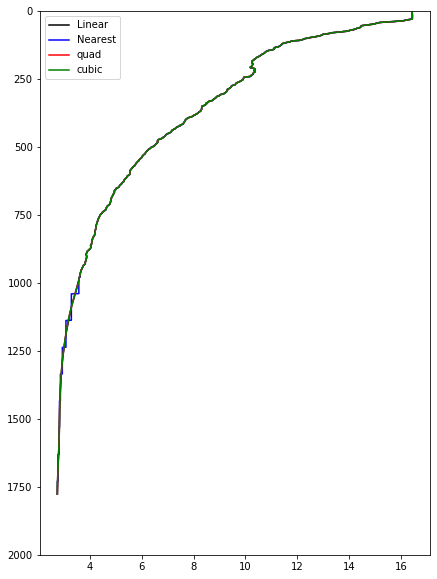

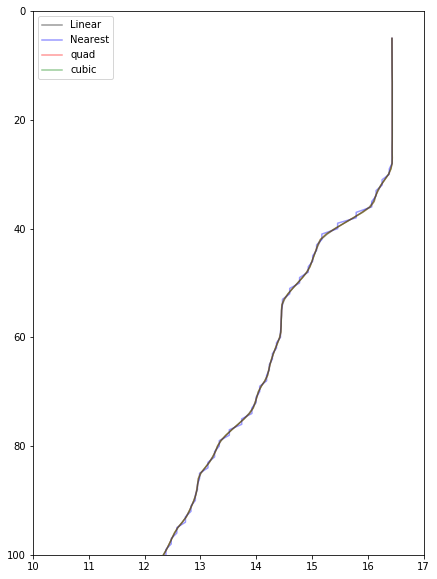

In [25]:
plt.figure(figsize = (7,10))
ax = plt.subplot()
ax.plot(soccom_temp_linear.sel(N_PROF = 0).values, soccom_temp_linear.depth, 'k-', label = 'Linear')
ax.plot(soccom_temp_nearest.sel(N_PROF = 0).values, soccom_temp_nearest.depth, 'b-', label = 'Nearest')
ax.plot(soccom_temp_quad.sel(N_PROF = 0).values, soccom_temp_quad.depth, 'r-', label = 'quad')
ax.plot(soccom_temp_cubic.sel(N_PROF = 0).values, soccom_temp_cubic.depth, 'g-', label = 'cubic')
ax.set_ylim([2000,0])
ax.legend(loc = 0)
plt.show()
plt.figure(figsize = (7,10))
ax = plt.subplot()
ax.plot(soccom_temp_linear.sel(N_PROF = 0).values, soccom_temp_linear.depth, 'k-', alpha = 0.4,label = 'Linear')
ax.plot(soccom_temp_nearest.sel(N_PROF = 0).values, soccom_temp_nearest.depth, 'b-', alpha = 0.4,label = 'Nearest')
ax.plot(soccom_temp_quad.sel(N_PROF = 0).values, soccom_temp_quad.depth, 'r-', alpha = 0.4,label = 'quad')
ax.plot(soccom_temp_cubic.sel(N_PROF = 0).values, soccom_temp_cubic.depth, 'g-', alpha = 0.4,label = 'cubic')
ax.set_ylim([100,0])
ax.set_xlim([10,17])
ax.legend(loc = 0)

plt.show()

In [26]:
ds = xr.Dataset({'linear':soccom_temp_linear, 'nearest': soccom_temp_nearest, 'cubic':soccom_temp_cubic, 'quad': soccom_temp_quad})
ds.attrs['description'] = 'All float Temperature interpolated onto a 1m vertical grid using linear, nearest neighbour, cublic spline and quadratic spline interpolation methods'
#ds.to_netcdf() # save it someplace

Note: sometimes the spline interpolation methods have instabilities, you should QC those interpolations.